# Importación de bibliotecas

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [61]:

from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta donde se guardarán los gráficos
save_path = '/content/drive/My Drive/Graficos/'

# Crear la carpeta si no existe
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carga de datos

In [62]:
# Cargar datos desde el archivo CSV
data = pd.read_csv('datos_piura.csv', delimiter=';')

# Convertir la columna de fechas a formato datetime
data['FECHA_MUESTRA'] = pd.to_datetime(data['FECHA_MUESTRA'], format='%Y%m%d')

# Inspeccionar los primeros registros del DataFrame
print(data.head())

  FECHA_MUESTRA        CUENCA            ESTACION UNIDAD_MEDIDA TIPO_ESTACION  \
0    2024-02-06  PRESA EJIDOS     CANAL PRINCIPAL           m3s  HIDROMETRICA   
1    2024-02-06  PRESA EJIDOS  PTE. SANCHEZ CERRO           m3s   HIDROLOGICA   
2    2024-02-06  PRESA EJIDOS        COTE EMBALSE          msnm         PRESA   
3    2024-02-06     RIO PIURA           EL PAPAYO           m3s   HIDROLOGICA   
4    2024-02-06     RIO PIURA         TAMBOGRANDE           m3s   HIDROLOGICA   

  DEPARTAMENTO PROVINCIA      DISTRITO  CAUDAL07H  PROMEDIO24H  MAXIMA24H  \
0        PiUra    PiUra       Castilla      42.37        42.39       0.00   
1        PiUra    PiUra       Castilla       6.00         2.25       6.00   
2        PiUra    PiUra       Castilla      30.78         0.00      30.78   
3        PiUra    PiUra       Castilla       0.00         0.00       0.00   
4        PiUra    PiUra   Tambo Grande       0.00         0.00       0.00   

   PRECIP24H  
0        0.0  
1        0.0  
2    

# Preprocesamiento de datos

In [63]:
# One-Hot Encoding para variables categóricas y normalización para variables numéricas
categorical_features = ['CUENCA', 'ESTACION', 'UNIDAD_MEDIDA', 'TIPO_ESTACION', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO']
numerical_features = ['PROMEDIO24H', 'MAXIMA24H', 'PRECIP24H']

# Preparar el preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Separar características y etiquetas
X = data.drop(columns=['CAUDAL07H', 'FECHA_MUESTRA'])
y = data['CAUDAL07H']

# Crear el pipeline de preprocesamiento
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicar el preprocesamiento a los datos
X_preprocessed = pipeline.fit_transform(X)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)


In [64]:
print("Dimensiones de X_train antes de la remodelación:", X_train.shape)

Dimensiones de X_train antes de la remodelación: (14061, 57)


In [65]:
X_train = X_train.toarray()

# Construcción y entrenamiento del modelo

In [66]:
# Reformatear X_train para que tenga la estructura (n_samples, n_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Arquitectura del Modelo
model = Sequential()
model.add(SimpleRNN(30, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(1))

# Compilación del Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del Modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/150
396/396 [==============================] - 5s 10ms/step - loss: 22038.9297 - val_loss: 13988.0244
Epoch 2/150
396/396 [==============================] - 5s 12ms/step - loss: 22996.3926 - val_loss: 14011.6660
Epoch 3/150
396/396 [==============================] - 6s 15ms/step - loss: 23445.4980 - val_loss: 13848.6113
Epoch 4/150
396/396 [==============================] - 4s 10ms/step - loss: 22185.0488 - val_loss: 13749.2676
Epoch 5/150
396/396 [==============================] - 4s 10ms/step - loss: 22615.1953 - val_loss: 13990.6777
Epoch 6/150
396/396 [==============================] - 6s 15ms/step - loss: 23460.7637 - val_loss: 13916.3652
Epoch 7/150
396/396 [==============================] - 4s 10ms/step - loss: 23438.4141 - val_loss: 13836.9912
Epoch 8/150
396/396 [==============================] - 4s 10ms/step - loss: 23002.2148 - val_loss: 13896.1436
Epoch 9/150
396/396 [==============================] - 6s 14ms/step - loss: 22228.0820 - val_loss: 8958.4072
Epoch 10/15

# Evaluación del modelo

In [67]:
X_test = X_test.toarray()

In [68]:

# Evaluación del Modelo
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Model Loss: {loss}')

# Predicciones del Modelo
predictions = model.predict(X_test_reshaped)

# Calcular la precisión del modelo
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')


189/189 [==============================] - 1s 4ms/step - loss: 1795.9098
Model Loss: 1795.9097900390625
189/189 [==============================] - 1s 4ms/step
R^2: 0.8911233299812003
MSE: 1795.9102439037554
MAE: 19.544891728682366


# Visualización de resultados

In [69]:
data.head(20)

,FECHA_MUESTRA,CUENCA,ESTACION,UNIDAD_MEDIDA,TIPO_ESTACION,DEPARTAMENTO,PROVINCIA,DISTRITO,CAUDAL07H,PROMEDIO24H,MAXIMA24H,PRECIP24H
0,2024-02-06,PRESA EJIDOS,CANAL PRINCIPAL,m3s,HIDROMETRICA,PiUra,PiUra,Castilla,42.37,42.39,0.00,0.0
1,2024-02-06,PRESA EJIDOS,PTE. SANCHEZ CERRO,m3s,HIDROLOGICA,PiUra,PiUra,Castilla,6.00,2.25,6.00,0.0
2,2024-02-06,PRESA EJIDOS,COTE EMBALSE,msnm,PRESA,PiUra,PiUra,Castilla,30.78,0.00,30.78,0.0
3,2024-02-06,RIO PIURA,EL PAPAYO,m3s,HIDROLOGICA,PiUra,PiUra,Castilla,0.00,0.00,0.00,0.0
4,2024-02-06,RIO PIURA,TAMBOGRANDE,m3s,HIDROLOGICA,PiUra,PiUra,Tambo Grande,0.00,0.00,0.00,3.7
5,2024-02-06,RIO PIURA,PTE. NACARA,m3s,HIDROMETRICA,PiUra,MorropOn,ChUlUcanas,0.00,0.00,0.00,2.2
6,2024-02-06,PRESA SULLANA,CANAL NORTE,m3s,HIDROLOGICA,PiUra,SUllana,SUllana,16.50,16.50,0.00,0.0
7,2024-02-06,PRESA SULLANA,RIO CHIRA(SULLANA),m3s,HIDROLOGICA,PiUra,SUllana,SUllana,10.00,13.30,20.00,0.0
8,2024-02-06,PRESA SULLANA,COTA EMBALSE,msnm,PRESA,PiUra,SUllana,SUllana,36.73,0.00,36.78,0.0
9,2024-02-06,PUNTOS DE CONTROL CD,CURUMUY,m3s,HIDROMETRICA,PiUra,PiUra,PiUra,0.00,38.61,0.00,0.0


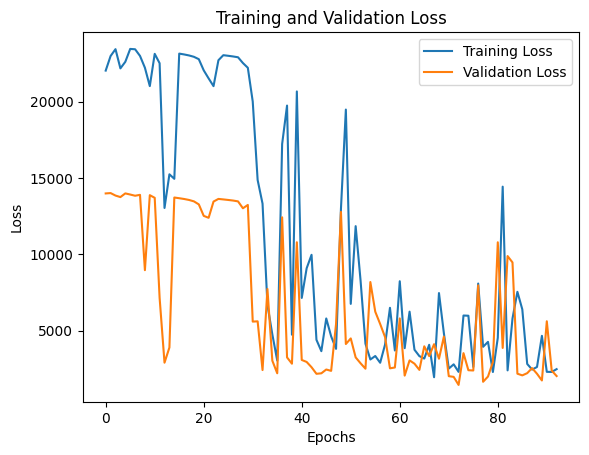

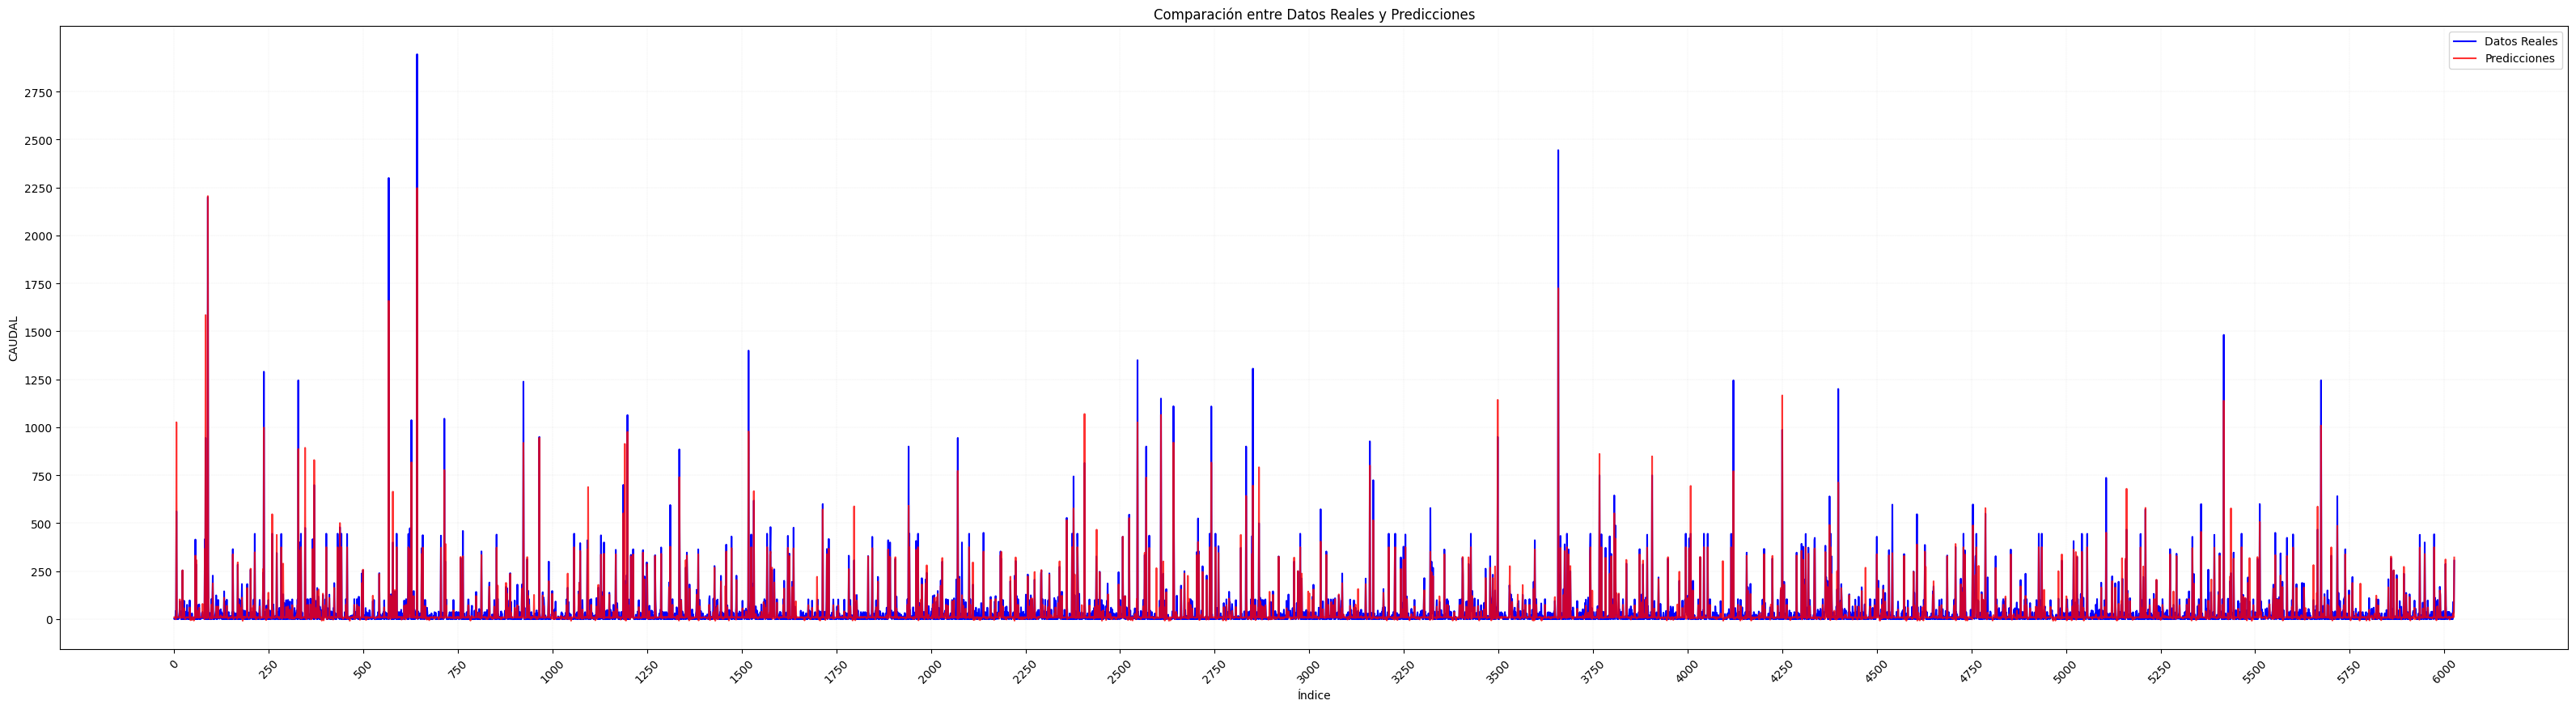

Precisión del modelo:
---------------------
R^2: 0.8911233299812003
MSE: 1795.9102439037554
MAE: 19.544891728682366
Precisión (R^2) del modelo: 89.11%


In [70]:
# Visualización de la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Visualización de la comparación entre datos reales y predicciones con barras de error
plt.figure(figsize=(40, 10))
plt.plot(y_test.values, label='Datos Reales', color='blue')
plt.plot(predictions, label='Predicciones', color='red', alpha=0.8)
#plt.fill_between(np.arange(len(predictions)), predictions[:,0] - np.std(predictions[:,0]), predictions[:,0] + np.std(predictions[:,0]), color='red', alpha=0.2)
#plt.errorbar(np.arange(len(predictions)), predictions[:,0], yerr=np.std(predictions[:,0]), fmt='o', color='red', markersize=5, label='Incertidumbre del Modelo')
plt.title('Comparación entre Datos Reales y Predicciones')
plt.xlabel('Índice')
plt.ylabel('CAUDAL')
plt.legend()

# Ajuste de los ejes
plt.xticks(np.arange(0, len(predictions), 250), rotation=45)
plt.yticks(np.arange(0, max(y_test.values), 250))
plt.grid(True, which='both', linestyle='--', linewidth=0.1)

plt.show()



# Evaluación de la precisión del modelo
print("Precisión del modelo:")
print("---------------------")
print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# Convertir la precisión a porcentaje
accuracy_percentage = r2 * 100
print(f'Precisión (R^2) del modelo: {accuracy_percentage:.2f}%')



<ipython-input-71-399737c226fa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['SEMESTRE'] = data_2022['FECHA_MUESTRA'].apply(obtener_semestre)
<ipython-input-71-399737c226fa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['SEMESTRE'] = data_2023['FECHA_MUESTRA'].apply(obtener_semestre)
<ipython-input-71-399737c226fa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

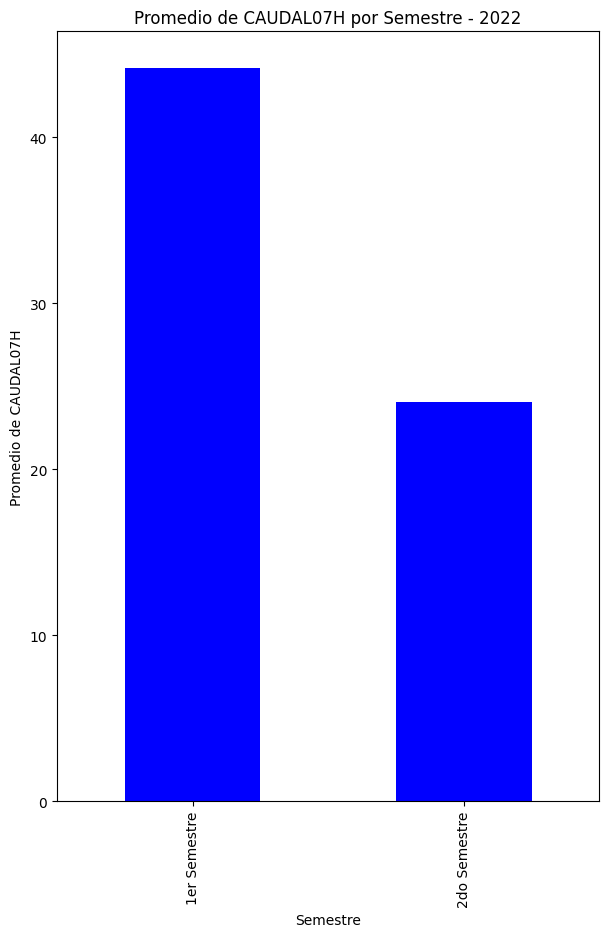

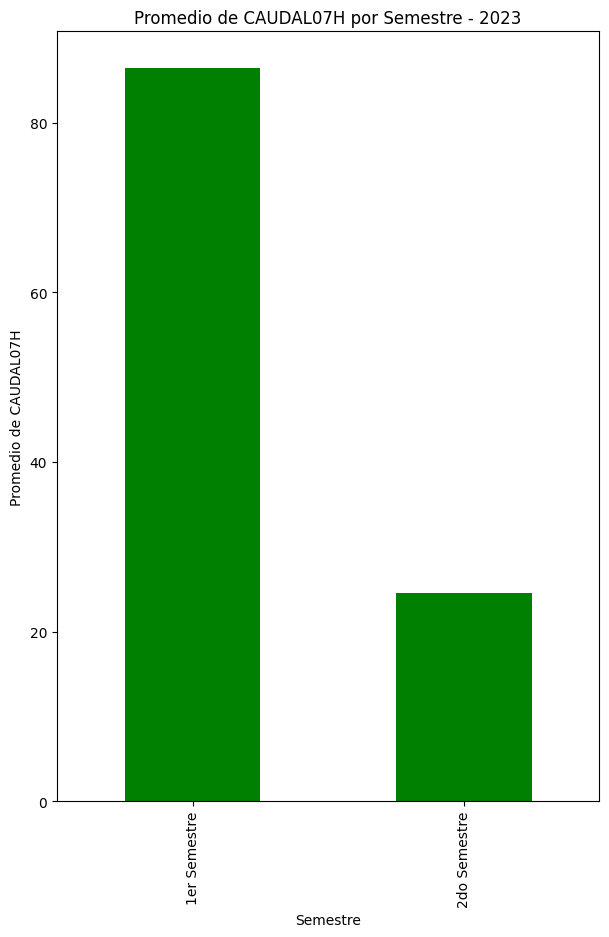

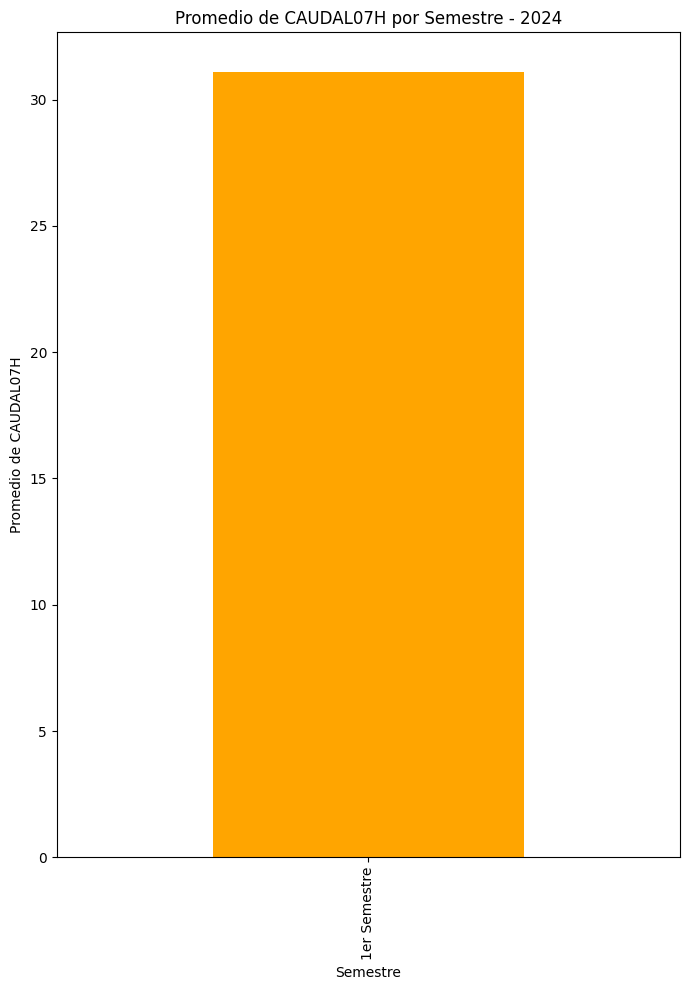

In [71]:
data_2022 = data[data['FECHA_MUESTRA'].dt.year == 2022]
data_2023 = data[data['FECHA_MUESTRA'].dt.year == 2023]
data_2024 = data[data['FECHA_MUESTRA'].dt.year == 2024]

# Definir una función para obtener el semestre a partir de la fecha
def obtener_semestre(fecha):
    if fecha.month <= 6:
        return '1er Semestre'
    else:
        return '2do Semestre'

# Aplicar la función para obtener el semestre a cada fila de datos
data_2022['SEMESTRE'] = data_2022['FECHA_MUESTRA'].apply(obtener_semestre)
data_2023['SEMESTRE'] = data_2023['FECHA_MUESTRA'].apply(obtener_semestre)
data_2024['SEMESTRE'] = data_2024['FECHA_MUESTRA'].apply(obtener_semestre)

# Agrupar por semestre y calcular el promedio de CAUDAL07H
promedio_2022 = data_2022.groupby('SEMESTRE')['CAUDAL07H'].mean()
promedio_2023 = data_2023.groupby('SEMESTRE')['CAUDAL07H'].mean()
promedio_2024 = data_2024.groupby('SEMESTRE')['CAUDAL07H'].mean()

# Crear gráficos de salida divididos por semestre para cada año
#plt.figure(figsize=(7, 20))

plt.figure(figsize=(7, 10))
promedio_2022.plot(kind='bar', color='blue')
plt.title('Promedio de CAUDAL07H por Semestre - 2022')
plt.xlabel('Semestre')
plt.ylabel('Promedio de CAUDAL07H')
plt.savefig(save_path + 'caudal_semestres_2022.png')

plt.figure(figsize=(7, 10))
promedio_2023.plot(kind='bar', color='green')
plt.title('Promedio de CAUDAL07H por Semestre - 2023')
plt.xlabel('Semestre')
plt.ylabel('Promedio de CAUDAL07H')
plt.savefig(save_path + 'caudal_semestres_2023.png')

plt.figure(figsize=(7, 10))
promedio_2024.plot(kind='bar', color='orange')
plt.title('Promedio de CAUDAL07H por Semestre - 2024')
plt.xlabel('Semestre')
plt.ylabel('Promedio de CAUDAL07H')
plt.savefig(save_path + 'caudal_semestres_2024.png')

plt.tight_layout()
plt.show()

<ipython-input-72-a049fe6c830f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['SEMESTRE'] = data_2022['FECHA_MUESTRA'].apply(obtener_semestre)
<ipython-input-72-a049fe6c830f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['SEMESTRE'] = data_2023['FECHA_MUESTRA'].apply(obtener_semestre)
<ipython-input-72-a049fe6c830f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

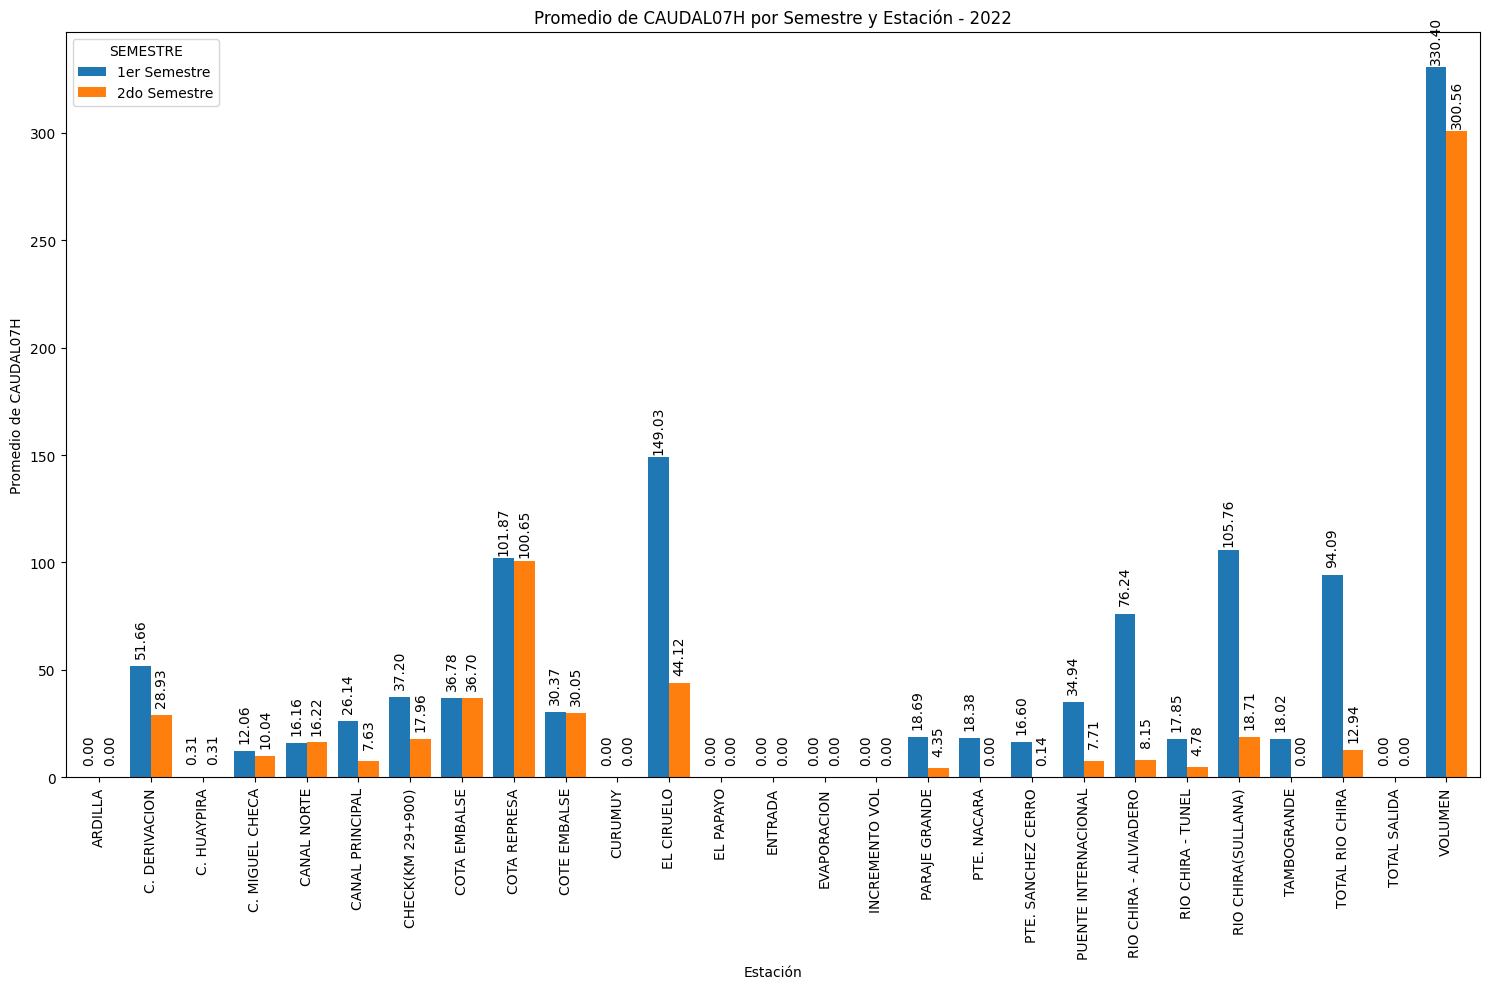

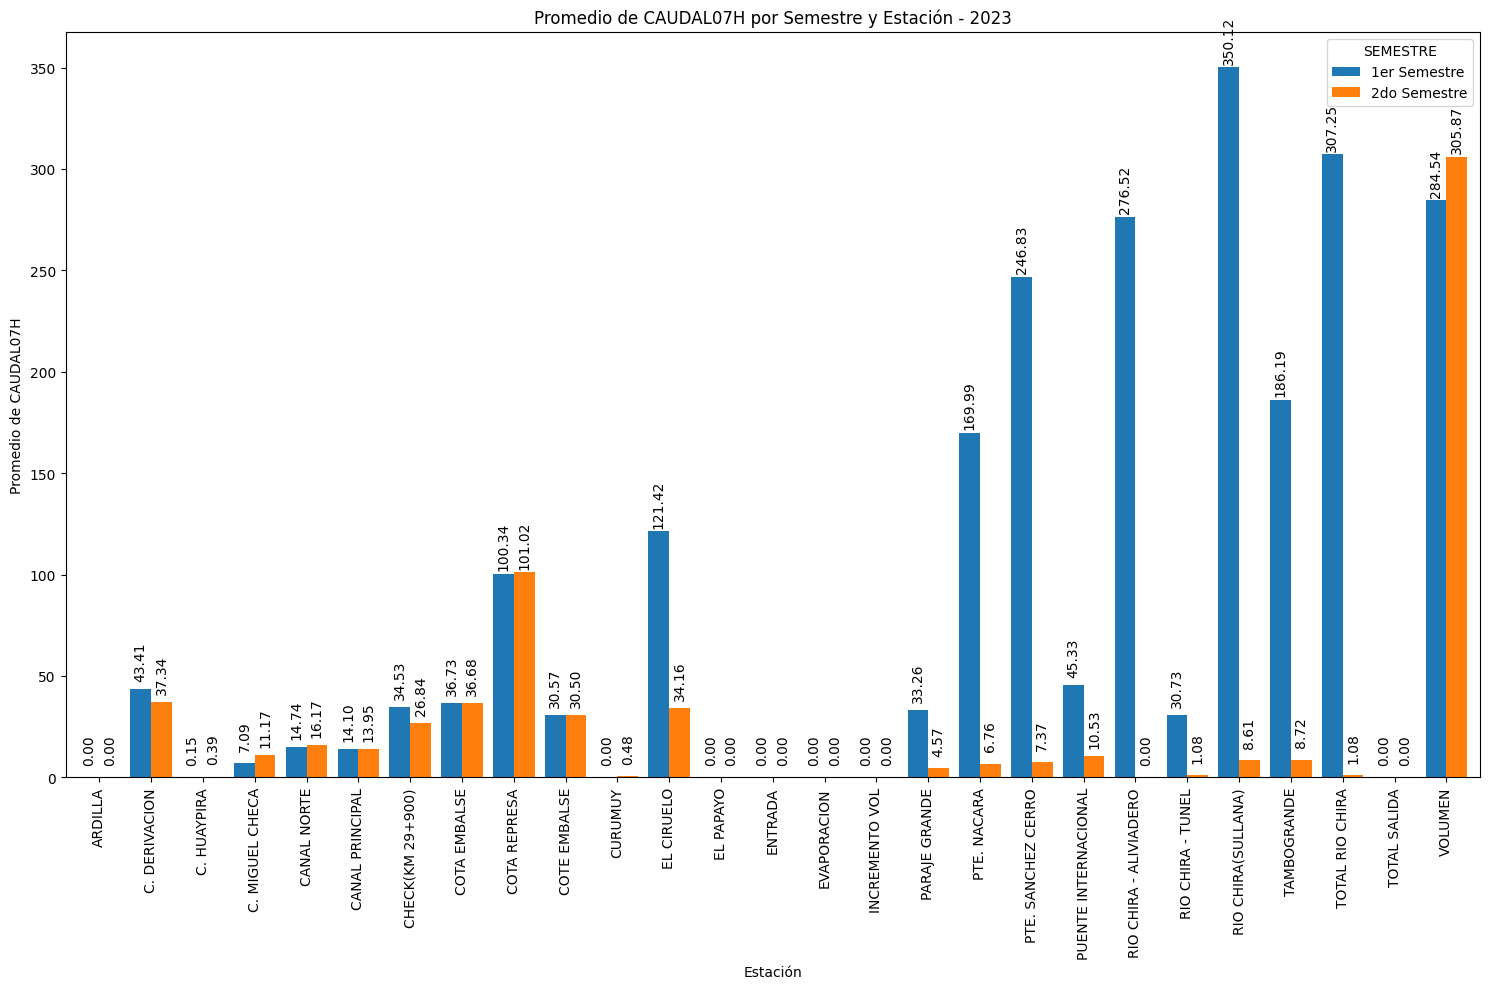

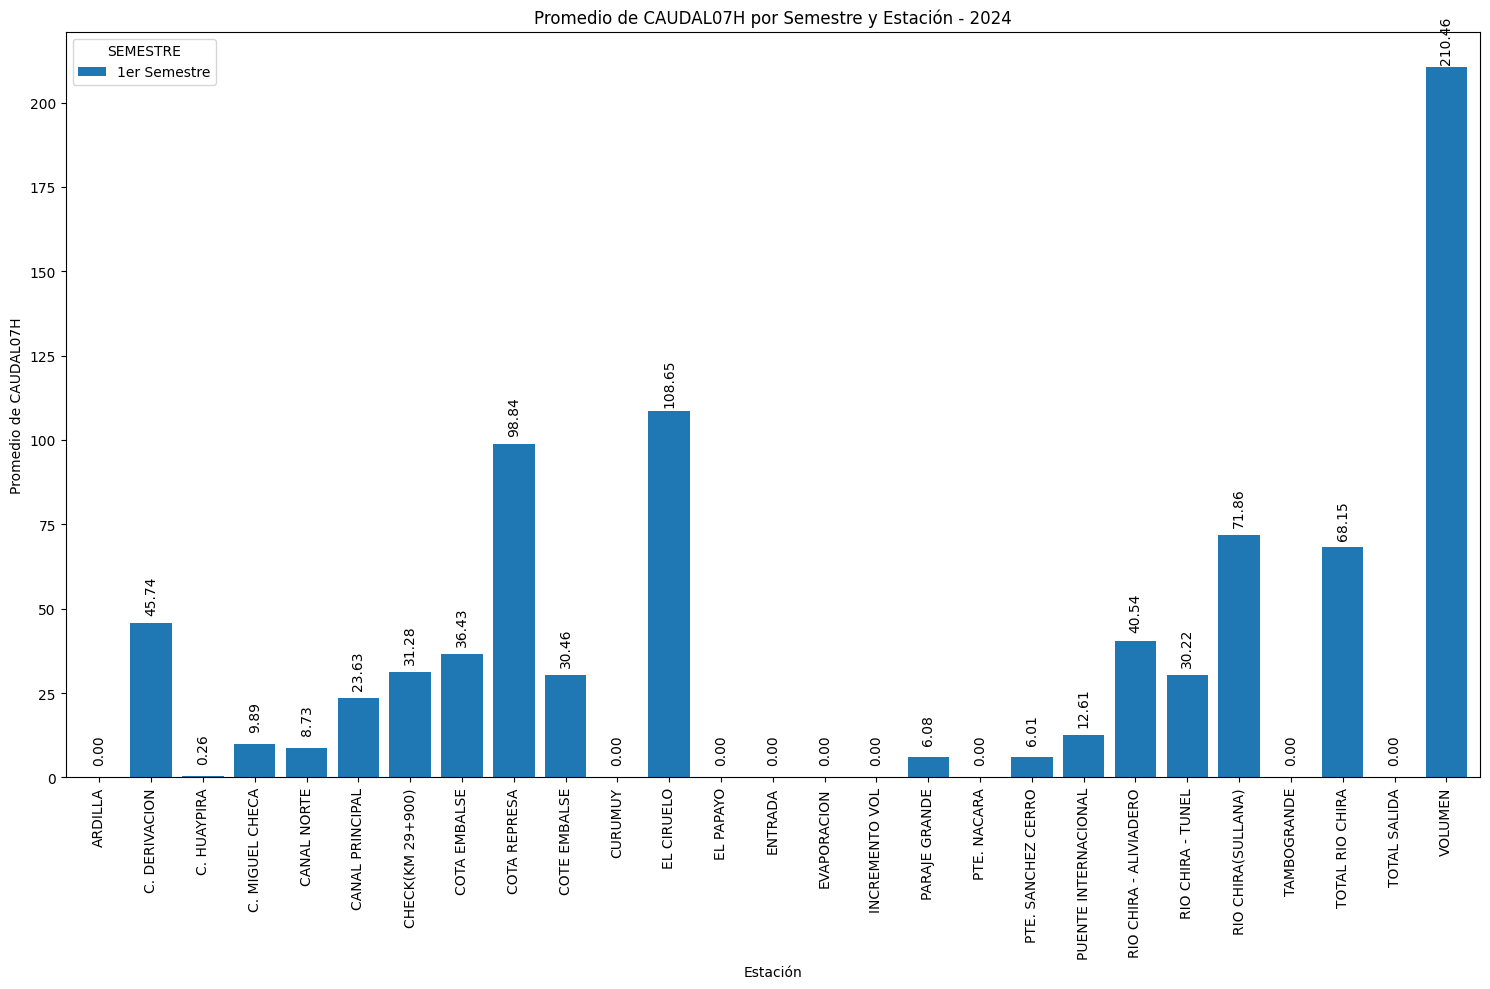

Gráficos guardados en Google Drive.


In [72]:


# Filtrar datos por año y semestre para 2022, 2023 y 2024
data_2022 = data[data['FECHA_MUESTRA'].dt.year == 2022]
data_2023 = data[data['FECHA_MUESTRA'].dt.year == 2023]
data_2024 = data[data['FECHA_MUESTRA'].dt.year == 2024]

# Definir una función para obtener el semestre a partir de la fecha
def obtener_semestre(fecha):
    return '1er Semestre' if fecha.month <= 6 else '2do Semestre'

# Aplicar la función para obtener el semestre a cada fila de datos
data_2022['SEMESTRE'] = data_2022['FECHA_MUESTRA'].apply(obtener_semestre)
data_2023['SEMESTRE'] = data_2023['FECHA_MUESTRA'].apply(obtener_semestre)
data_2024['SEMESTRE'] = data_2024['FECHA_MUESTRA'].apply(obtener_semestre)

# Agrupar por estacion, semestre y calcular el promedio de CAUDAL07H
promedio_2022 = data_2022.groupby(['ESTACION', 'SEMESTRE'])['CAUDAL07H'].mean().unstack()
promedio_2023 = data_2023.groupby(['ESTACION', 'SEMESTRE'])['CAUDAL07H'].mean().unstack()
promedio_2024 = data_2024.groupby(['ESTACION', 'SEMESTRE'])['CAUDAL07H'].mean().unstack()

# Función para agregar etiquetas con valores encima de cada barra
def etiquetas_sobre_barras(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 20), textcoords='offset points', rotation=90)

# Gráfico 2022
plt.figure(figsize=(15, 10))
ax1 = promedio_2022.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Promedio de CAUDAL07H por Semestre y Estación - 2022')
plt.xlabel('Estación')
plt.ylabel('Promedio de CAUDAL07H')
etiquetas_sobre_barras(ax1)
plt.tight_layout()
plt.savefig(save_path + 'caudal_2022.png')
#plt.close()

# Gráfico 2023
plt.figure(figsize=(15, 10))
ax2 = promedio_2023.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Promedio de CAUDAL07H por Semestre y Estación - 2023')
plt.xlabel('Estación')
plt.ylabel('Promedio de CAUDAL07H')
etiquetas_sobre_barras(ax2)
plt.tight_layout()
plt.savefig(save_path + 'caudal_2023.png')
#plt.close()

# Gráfico 2024
plt.figure(figsize=(15, 10))
ax3 = promedio_2024.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Promedio de CAUDAL07H por Semestre y Estación - 2024')
plt.xlabel('Estación')
plt.ylabel('Promedio de CAUDAL07H')
etiquetas_sobre_barras(ax3)
plt.tight_layout()
plt.savefig(save_path + 'caudal_2024.png')
#plt.close()

plt.show()

print('Gráficos guardados en Google Drive.')
